In [1]:
!pip install -q transformers ipyplot==1.1.0 ftfy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.4/53.4 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 36.3 MB/s eta 0:00:00


In [2]:
from io import BytesIO
from PIL import Image
import requests
import ipyplot

from transformers import CLIPProcessor, CLIPModel
import torch


        WARNING! Google Colab Environment detected!
        You might encounter issues while running in Google Colab environment.
        If images are not displaying properly please try setting `base_64` param to `True`.
        


In [3]:
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/568 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

In [4]:
original_api = "https://pixabay.com/api/?key="
pixabay_api_key = "42385635-fe0c7262ac4d1baff7453bb95"

In [5]:
#@title Enter the queries
semantic_search_phrase = "Orange Fruit"
pixabay_search_keyword = "Fruits"

In [6]:
no_to_retrieve = 20
pixabay_api = original_api+pixabay_api_key+"&q="+pixabay_search_keyword.lower()+"&image_type=photo&safesearch=true&per_page="+str(no_to_retrieve)
response = requests.get(pixabay_api)
output = response.json()

all_images =[]
for each in output["hits"]:
    imageurl = each["webformatURL"]
    response = requests.get(imageurl)
    image = Image.open(BytesIO(response.content)).convert("RGB")
    all_images.append(image)

print ("Total no of images retrived: ",len(all_images))


Total no of images retrived:  20



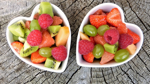
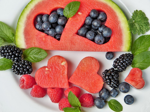
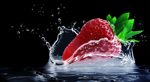
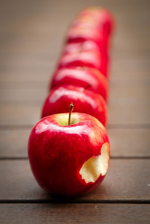
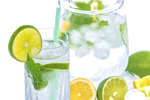
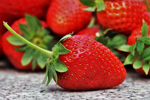
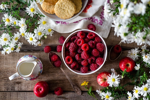
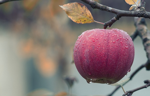
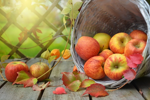
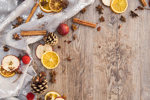
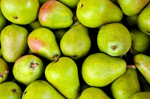
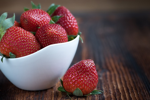
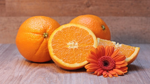
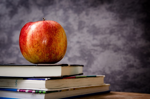
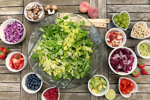
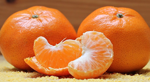
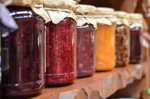
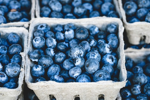
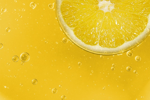
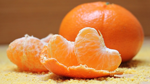


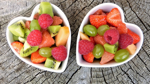
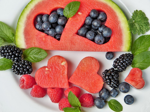
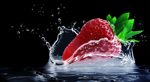
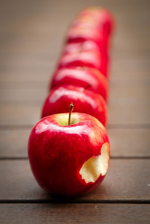
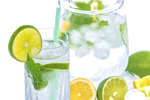
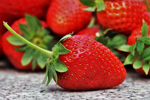
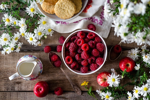
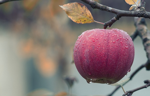
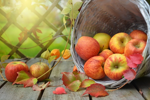
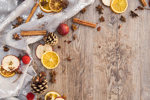
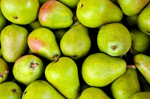
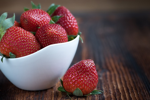
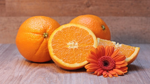
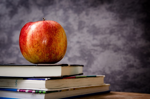
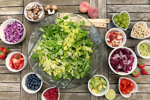
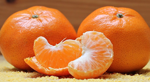
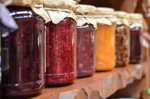
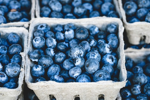
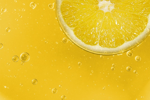
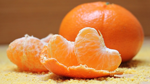

In [7]:
ipyplot.plot_images(all_images,max_images=50,img_width=150)

### Semantic Search CLIP

In [8]:
# Obtain the text-image similarity scores
with torch.no_grad():
    inputs = processor(text=[semantic_search_phrase],
                    images=all_images, return_tensors="pt", padding=True)
    outputs = model(**inputs)

In [9]:
logits_per_image = outputs.logits_per_image # this is the image-text similarity score
probs = logits_per_image.softmax(dim=1) # we can take the softmax to get the label probabilities

print(logits_per_image.shape, probs.shape)

torch.Size([20, 1]) torch.Size([20, 1])


In [10]:
# Filter the scores and return indices
values, indices = logits_per_image.squeeze().topk(3) # Top-3

top_images, top_scores = [], []

for score, index in zip(values, indices):
    top_images.append(all_images[int(index.numpy())])
    score = score.numpy().tolist()
    top_scores.append(round(score, 3))

Scores: [31.789, 31.782, 29.951]



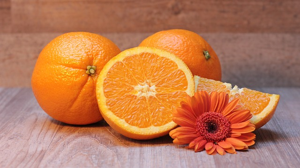
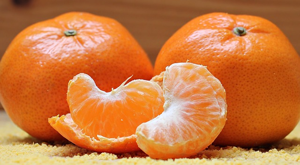
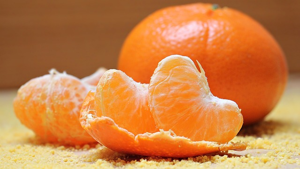


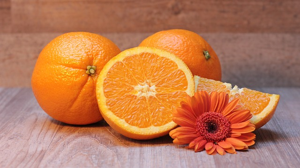
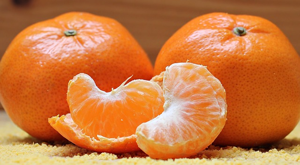
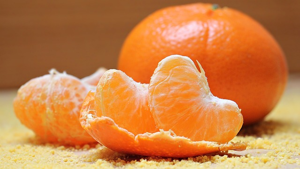

In [11]:
print (f"Scores: {top_scores}")
ipyplot.plot_images(top_images, img_width=300)